### Problem Statement
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.



### Data Dictionary
* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [149]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs


# to visualize the elbow curve and silhouette scores
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist


# set the background for the graphs
plt.style.use('ggplot')

# For pandas profiling
#from pandas_profiling import ProfileReport

# Printing style
from tabulate import tabulate

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')


from scipy.stats import zscore
from scipy.spatial.distance import cdist

#### Loading dataset

In [150]:
#load dataset
bank_cc = pd.read_excel('/Users/mac/Documents/PG AI MACHINE LEARNING/Credit+Card+Customer+Data.xlsx')

#### Data Sanity Checks

In [151]:
#view dataset
bank_cc.head()


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [152]:
#view data dimension
print('the dataset has:',bank_cc.shape[0],'rows and',bank_cc.shape[1],'columns')

the dataset has: 660 rows and 7 columns


In [153]:
#check data structure
bank_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [154]:
#check data statistics
bank_cc.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.000,330.500,190.670,1.000,165.750,330.500,495.250,660.000
Customer Key,660.000,55141.444,25627.772,11265.000,33825.250,53874.500,77202.500,99843.000
Avg_Credit_Limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
Total_Credit_Cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
Total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
Total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
Total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


#### Observations:
* The average credit limit ranges from 3,000 to 200,000, though there is a sharp upshoot from the 75th percentile of 48,000 to the max suggesting possible outliers
* A customer can have up to 10 credit cards but majority have about 6 credit cards
* Customers' online visit ranges from none to 15 times, possible outliers observed here. Physical visitation to bank ranges from none to 5 times. So it appears contact preference for customers is via online 

In [155]:
#check missing values
bank_cc.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

no missing values observed

In [156]:
#check duplicate values
bank_cc.duplicated().sum()

0

#### We do not need the Sl_No column so this will be dropped

In [157]:
#drop unwanted column
bank_cc = bank_cc.drop(columns = 'Sl_No', axis =1)

## Exploratory Data Analysis
### Univariate Analysis

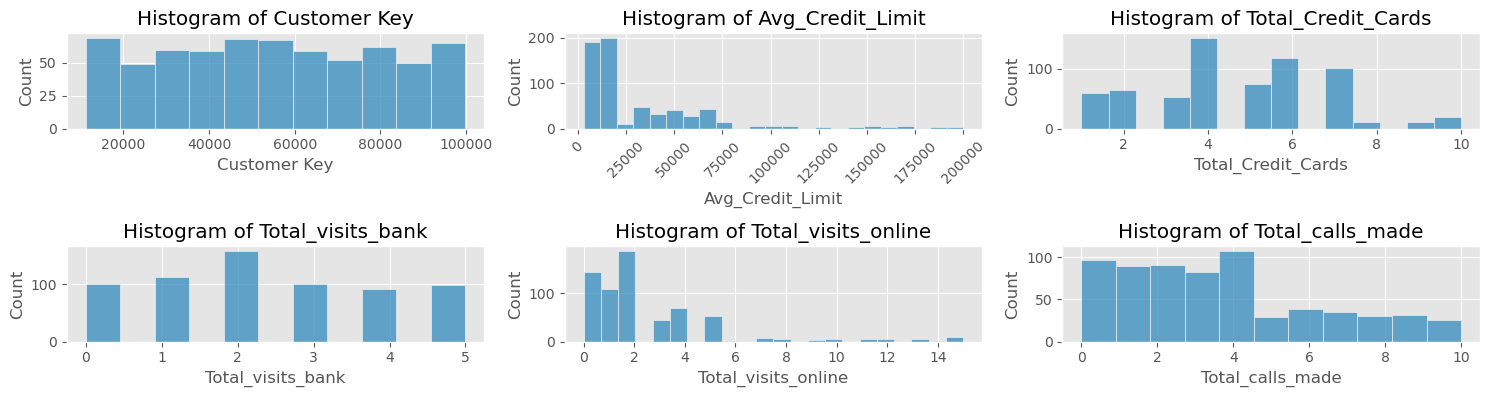

In [158]:
#histogram for all variables
fig, axes = plt.subplots( figsize=(15, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=1.2,wspace=0.8)
#plot a 2X3 histogram for each of the variables
for i, col in enumerate(bank_cc):
    plt.subplot(5, 3, i + 1)
    sns.histplot(data = bank_cc, x =col)
    plt.tight_layout()
    plt.title(f"Histogram of {col}")
    if col == 'Avg_Credit_Limit': #to properly align the x values of this variable
        plt.xticks(rotation=45)
   
    

plt.show()

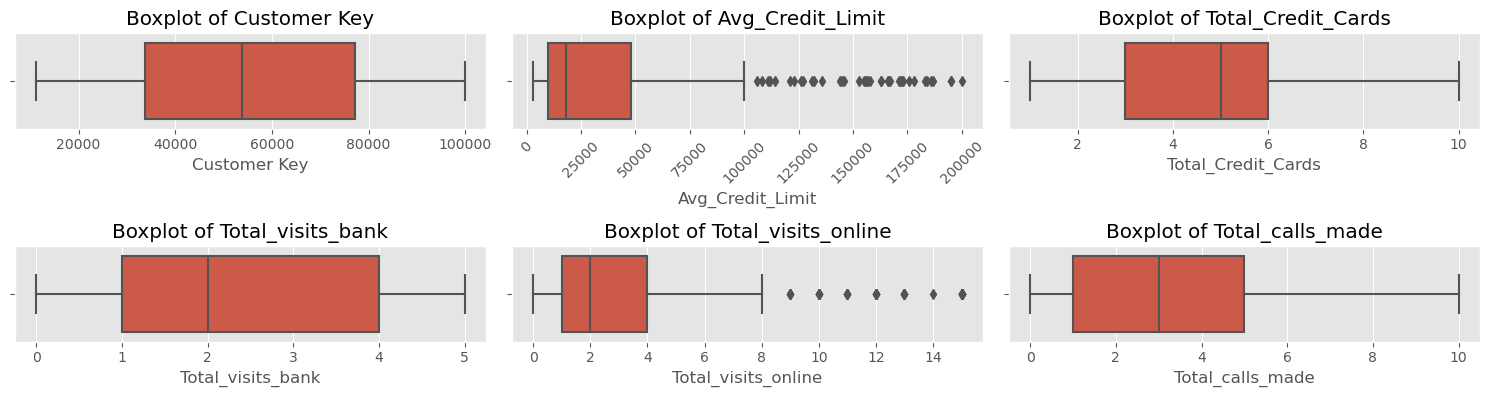

In [159]:
#boxplot for all variables
fig, axes = plt.subplots( figsize=(15, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=1.2,wspace=0.8)
#plot a 2X3 boxplot for each of the categorical variables
for i, col in enumerate(bank_cc):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data = bank_cc, x =col)
    plt.tight_layout()
    plt.title(f"Boxplot of {col}")
    if col == 'Avg_Credit_Limit': #to properly align the x values of this variable
        plt.xticks(rotation=45)
   
    

plt.show()

Observations:
* Avg_credit_limit is left skewed with outliers. Same observation for Total_visits_online
* Majority of the existing credit limits is below 25,000
* Modal total visitation for both online and physical is 2
* It appears customers call mostly up to 4 times
* Majority of the customers hold about 4 cards

### Bivariate Analysis

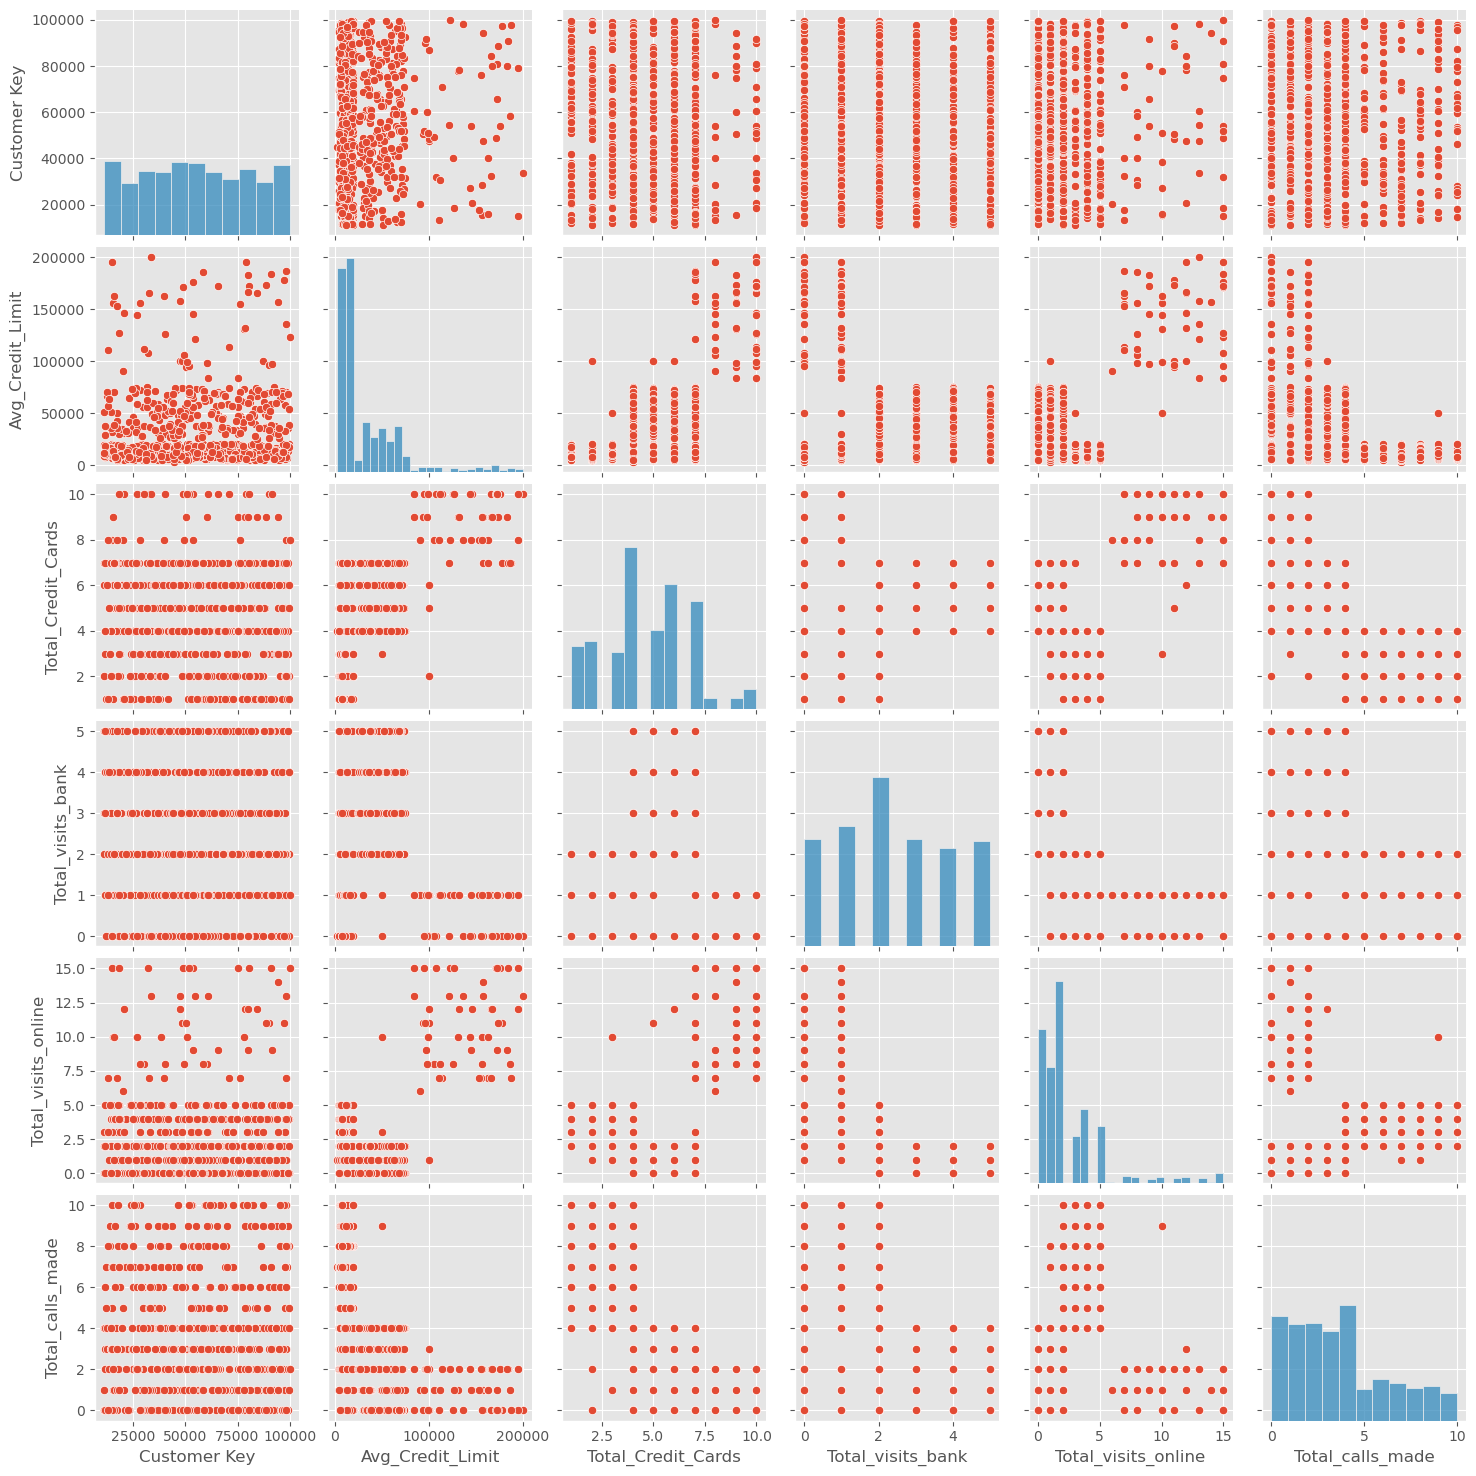

In [160]:
sns.pairplot(data=bank_cc)


#### observation:
there is a weak relationship among most variables

In [161]:
# Let's see the correlation matrix of variables to observe extent of relationship
bank_cc.corr()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Customer Key,1.000,0.069,-0.010,-0.001,0.023,0.006
Avg_Credit_Limit,0.069,1.000,0.609,-0.100,0.551,-0.414
Total_Credit_Cards,-0.010,0.609,1.000,0.316,0.168,-0.651
Total_visits_bank,-0.001,-0.100,0.316,1.000,-0.552,-0.506
Total_visits_online,0.023,0.551,0.168,-0.552,1.000,0.127
Total_calls_made,0.006,-0.414,-0.651,-0.506,0.127,1.000


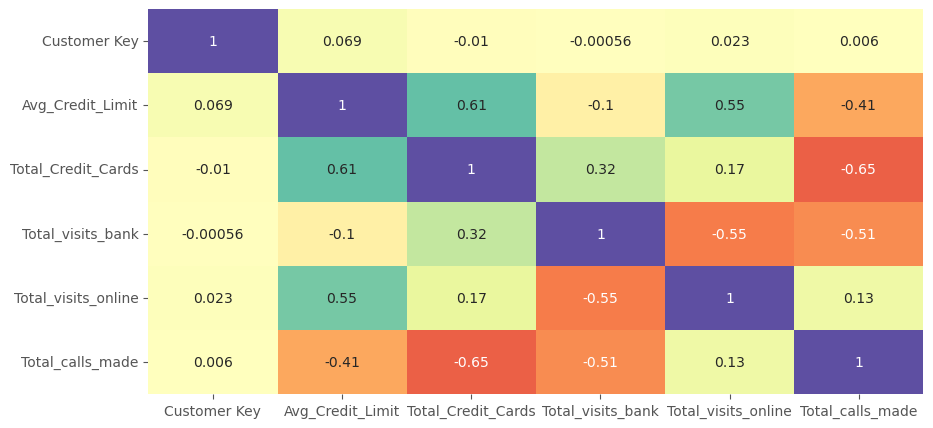

In [162]:
#visualise correlation
plt.figure(figsize=(10,5))
sns.heatmap(bank_cc.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1,cbar= False)
#plt.xticks(rotation = 80)
plt.show()

#### Observations:
* Strong positive correlation exists between avg_credit_limit and total_credit_cards while a strong negative correlation is observed between total_calls_made and total_credit_card
* While there is a good positive correlation between avg_credit_limit and online visits,there is observed negative correlation between the former and physical bank visits 
* strong negative correlation between total credit cards and total calls made which is expected as supposed complaints and enquiries from card holders.

#### The Avg_Credit_Limit appears to be of business interest and could generate valuable insights for the bank. Hence, we will see a box plot interaction of this variable with some selected variables

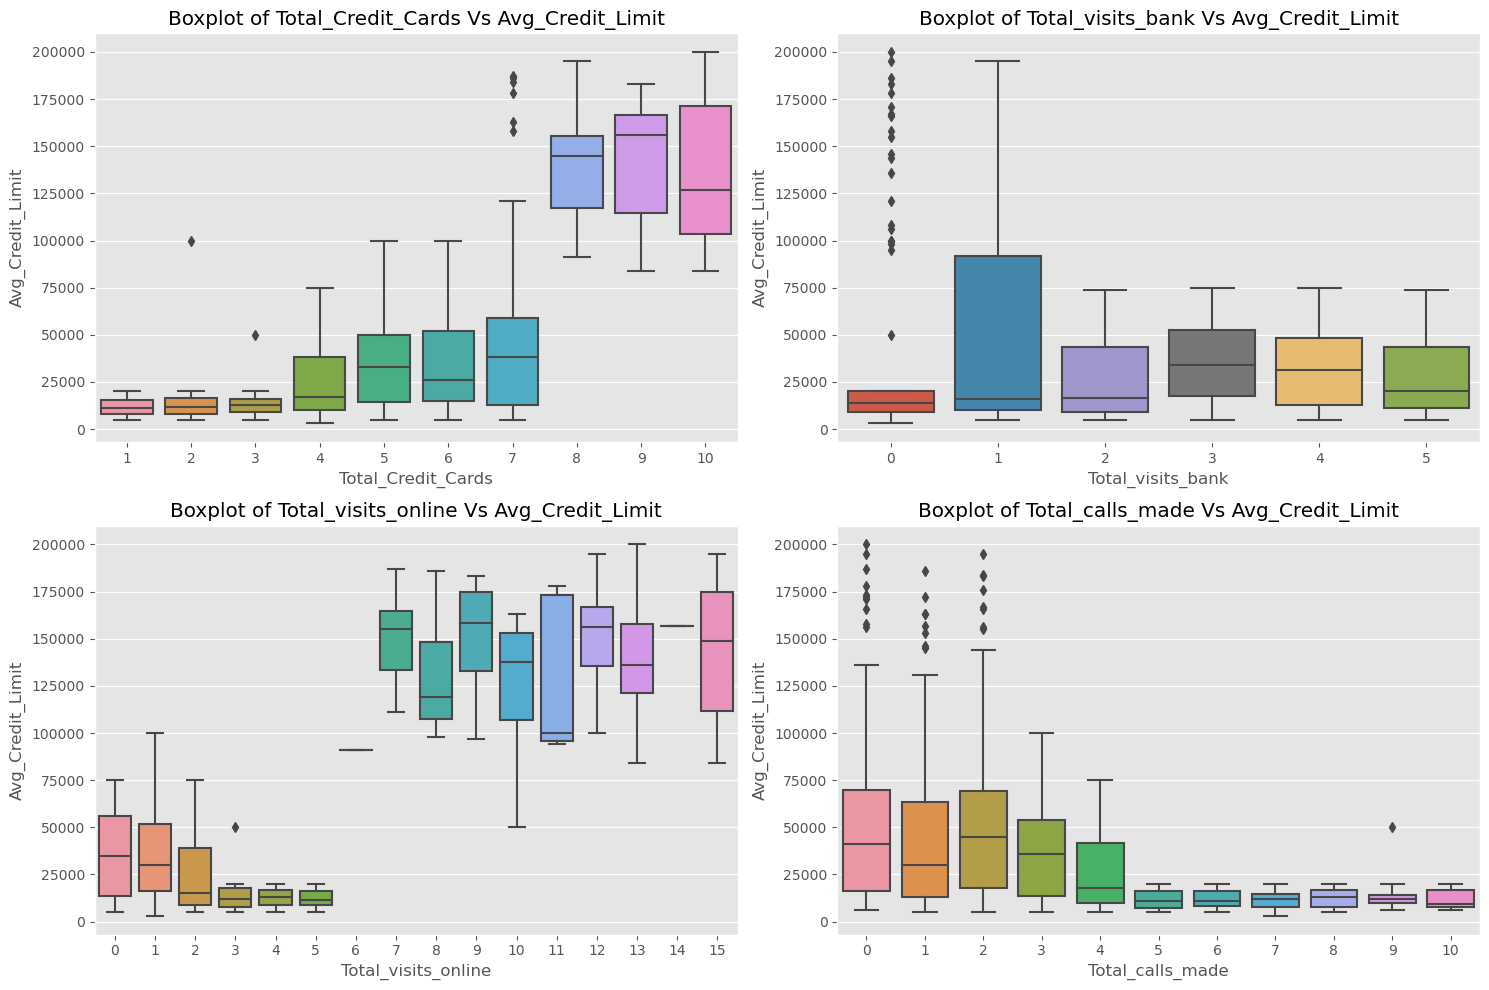

In [163]:
#to investigate interaction of credit limit with some variables
fig, axes = plt.subplots( figsize=(15, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=1.2,wspace=0.8)
#create list of variables to observe
var_list = ['Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']
var_list2 = ['Total_Credit_Cards','Total_visits_bank','Total_visits_online','Avg_Credit_Limit','Total_calls_made']
#plot a 2X2 boxplot for each of the selected variables vs avg_credit_card
for i, col in enumerate(var_list):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data = bank_cc, x =col,y ='Avg_Credit_Limit')
    plt.tight_layout()
    plt.title(f"Boxplot of {col} Vs Avg_Credit_Limit")  
#show plot
plt.show()

#### Observations:
* the boxplots above reveals some pattern of segmentation in customer behaviour in relation to their credit limit
* Higher limit holders have more credit cards with more online visits , less physical visits and less calls made

### Data Pre-processing for clustering analysis
#### Scaling

In [164]:
#using z score to scale the data
bank_cc_new=bank_cc.iloc[:,1:]
bank_cc_scaled=bank_cc_new.apply(zscore)


### K-Means Clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

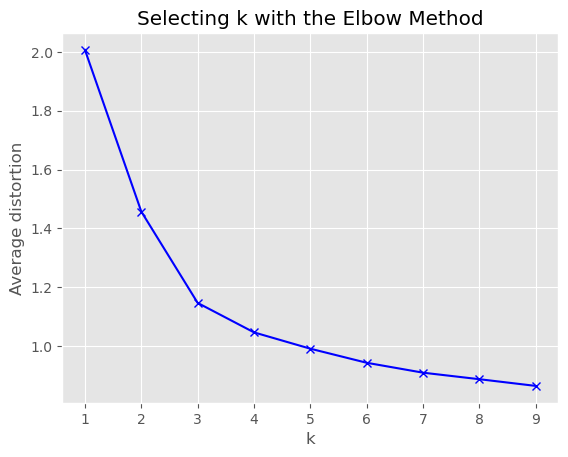

In [165]:
#Finding optimal no. of clusters

clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(bank_cc_scaled)
    prediction=model.predict(bank_cc_scaled)
    meanDistortions.append(sum(np.min(cdist(bank_cc_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / bank_cc_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

2 and 3 appears to be the optimal k. We will use the silhoutte score to determine the optimal value of k

### Silhoutte score

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25516863727620004
For n_clusters = 7, silhouette score is 0.24836605319652433
For n_clusters = 8, silhouette score is 0.22701240622895347
For n_clusters = 9, silhouette score is 0.24083782854395344


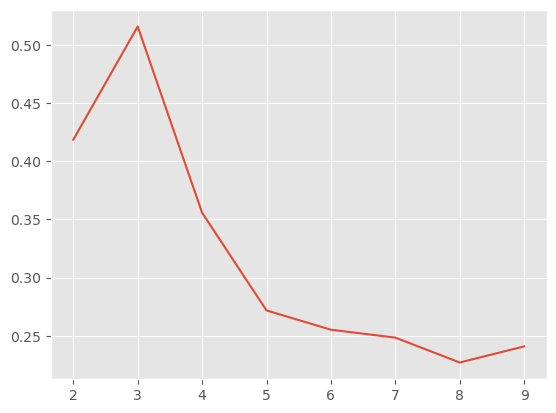

In [166]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((bank_cc_scaled))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(bank_cc_scaled, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

#### From the silhoutte plot above, we can determine that 3 is the optimal K

Customer profiling with K = 3 

In [167]:
# Let us first start with K = 3
final_model=KMeans(3)
final_model.fit(bank_cc_scaled)
prediction=final_model.predict(bank_cc_scaled)

#Append the prediction 
bank_cc["GROUP"] = prediction
bank_cc_scaled["GROUP"] = prediction
print("Groups Assigned : \n")
bank_cc.head()

Groups Assigned : 



,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,87073,100000,2,1,1,0,0
1,38414,50000,3,0,10,9,1
2,17341,50000,7,1,3,4,0
3,40496,30000,5,1,1,4,0
4,47437,100000,6,0,12,3,2


### Applying KMeans clustering for k=3


In [168]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(bank_cc_scaled)

KMeans(n_clusters=3, random_state=0)

In [169]:
# adding kmeans cluster labels to the original dataframe
bank_cc["K_means_segments"] = kmeans.labels_

In [170]:
cluster_profile = bank_cc.groupby("K_means_segments").mean()

In [171]:
cluster_profile["count_in_each_segment"] = (
    bank_cc.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [172]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,count_in_each_segment
K_means_segments,,,,,,,,
0,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,386
1,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,1.000000,224
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50


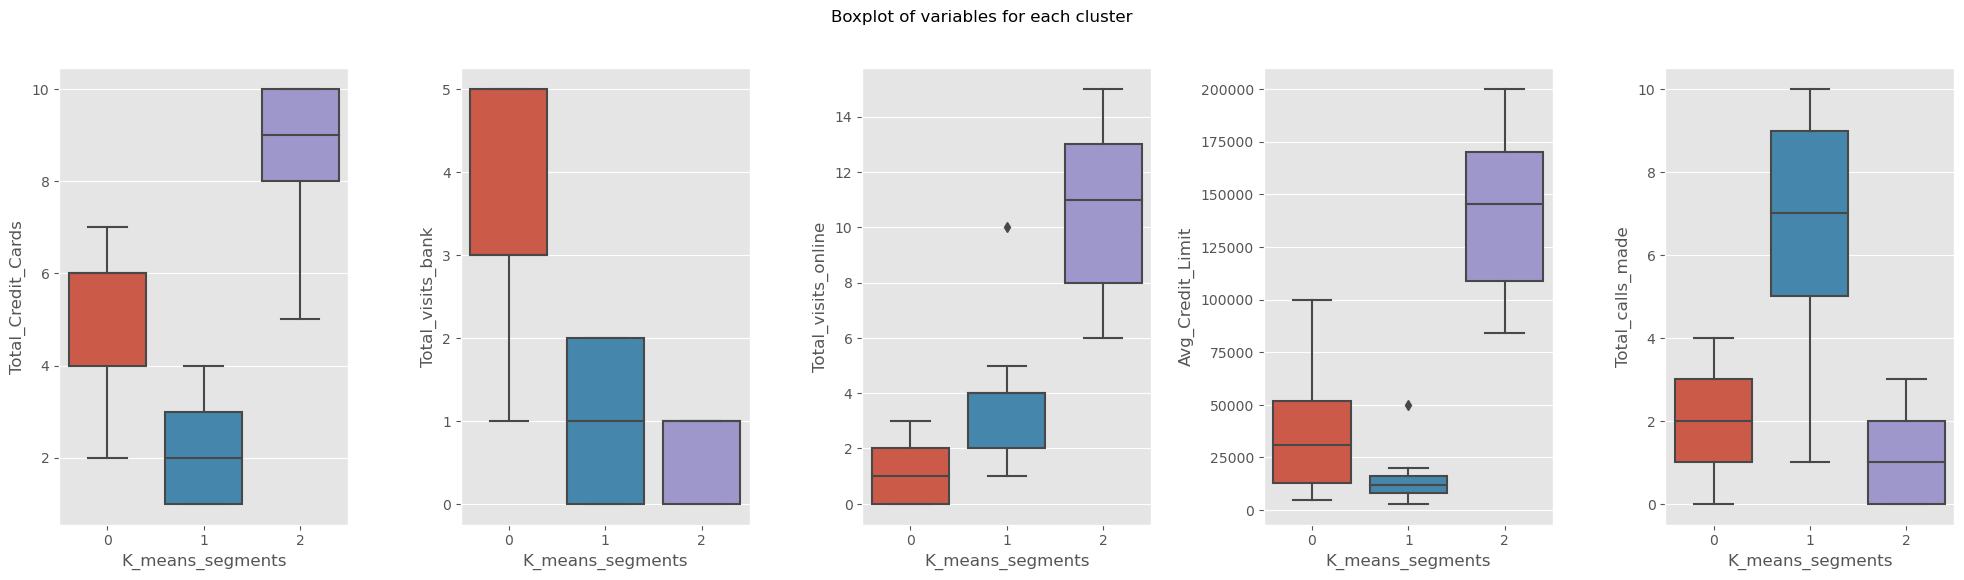

In [173]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle("Boxplot of variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=bank_cc[var_list2[counter]], x=bank_cc["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### observations:
#### Cluster 0:
* Total credit cards is moderate , 4-6
* This cluster appear to visit the bank more regularly than others
* Their online visit traffic is very minimal
* Average credit limit is considered small, below 50,000
* No of calls is moderate

#### Cluster 1:
* Total credit cards is very low
* Bank visitation is not so regular like cluster 0
* Their online visit traffic is higher than cluster 0
* Average credit limit is considered the least
* No of calls is highest

#### Cluster 2:
* Total credit cards is highest
* Total bank visits is the least
* Their online visit traffic is the highest
* Average credit limit is highest
* No of calls is the least

### Hierarchical Clustering

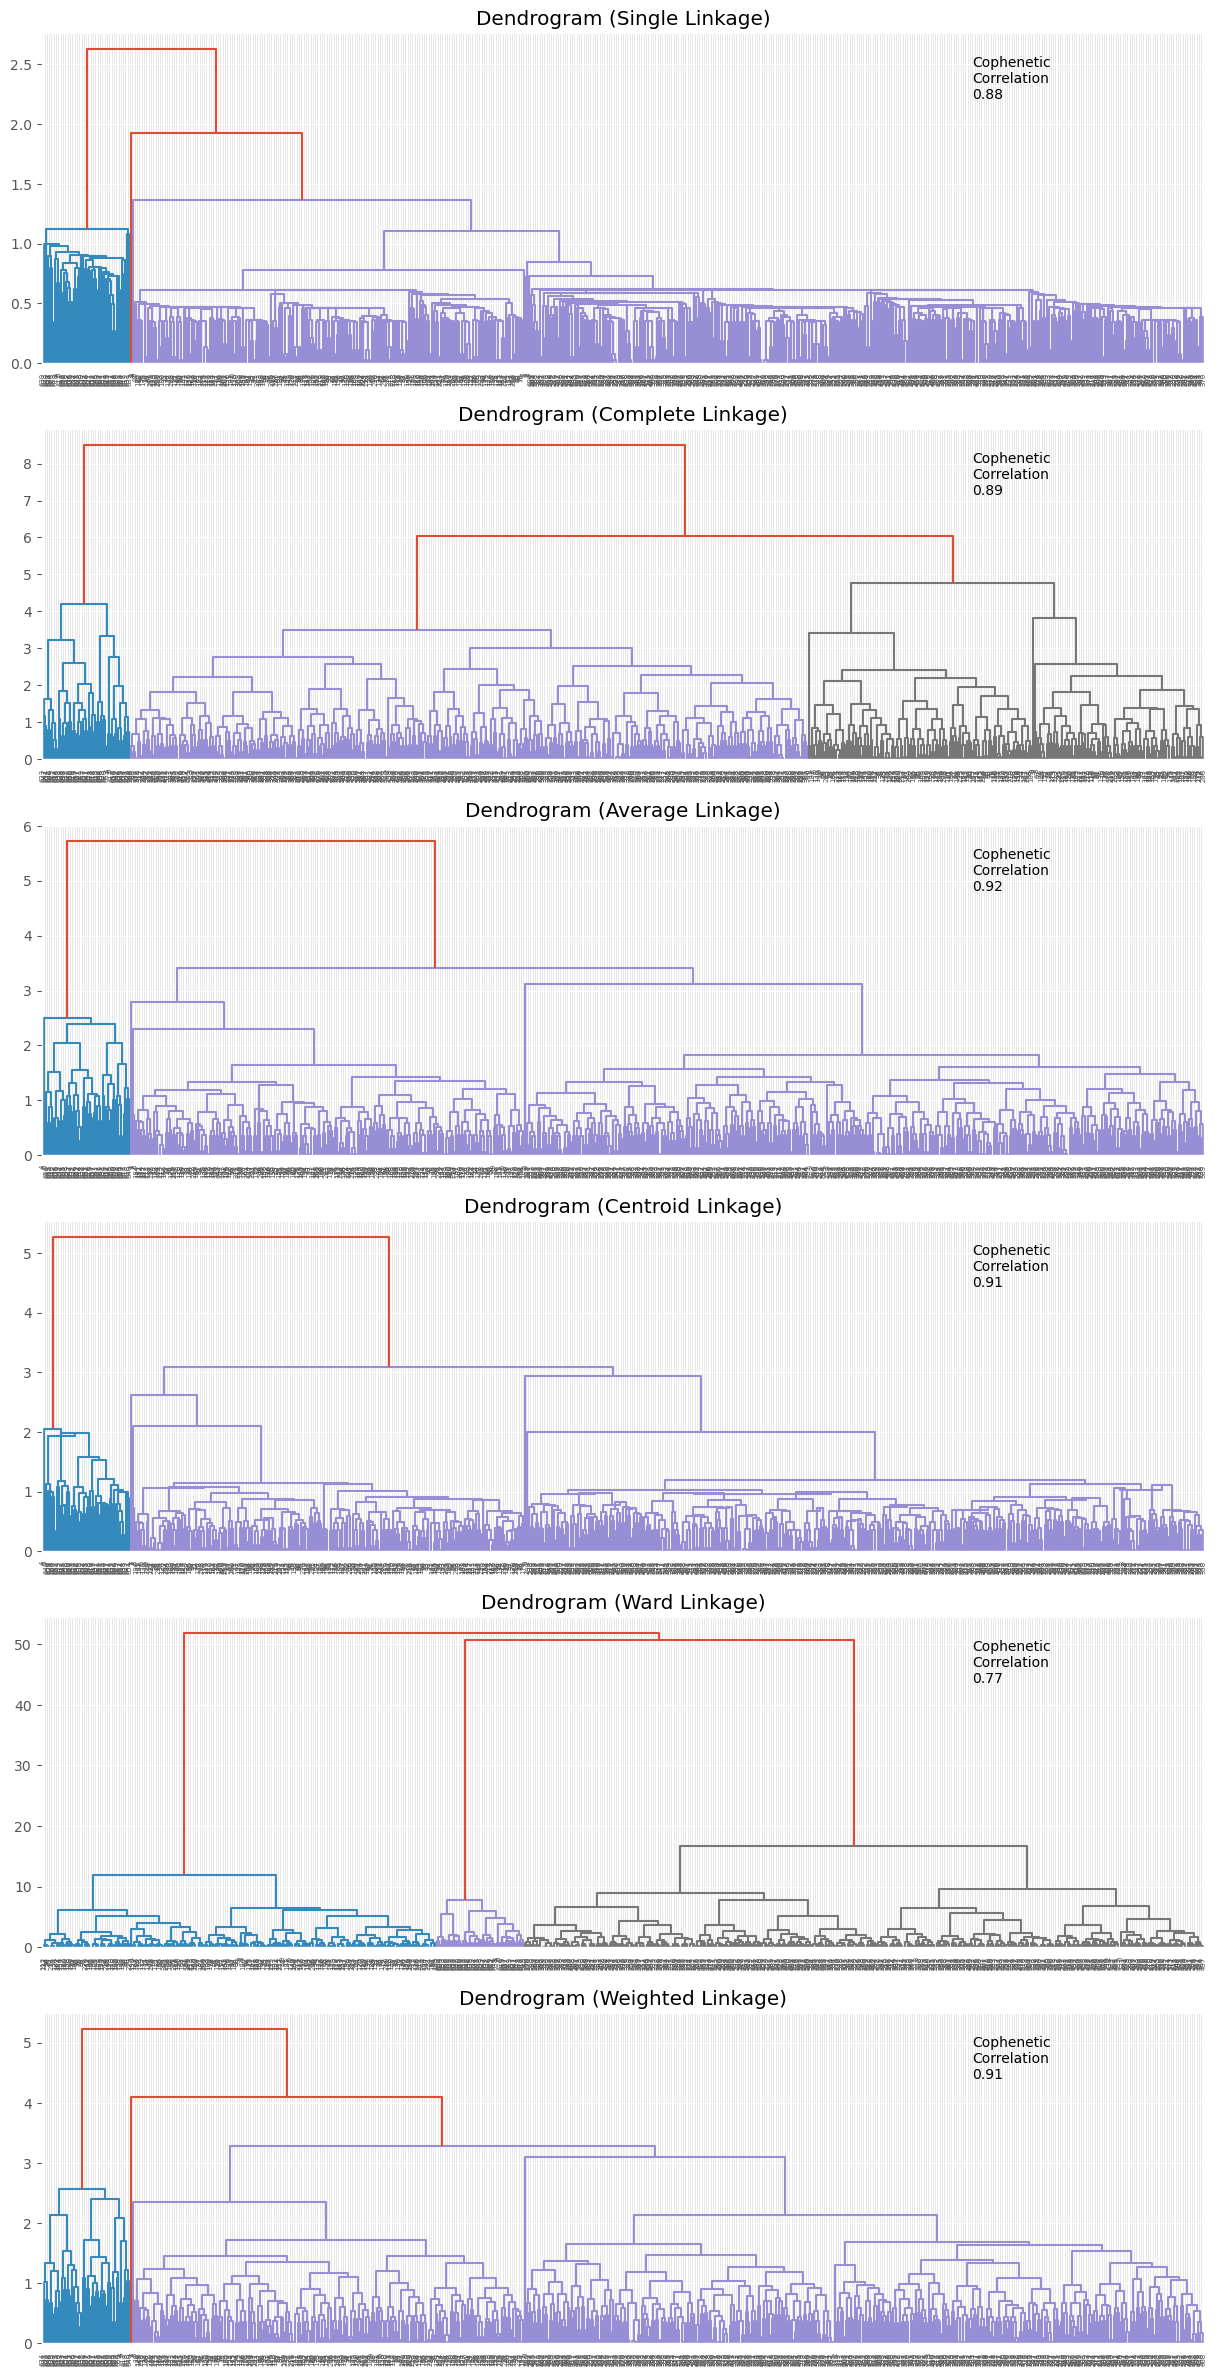

In [174]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(bank_cc_scaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(bank_cc_scaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [175]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(bank_cc_scaled, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(bank_cc_scaled))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8788676940541079.
Cophenetic correlation for complete linkage is 0.8860521900934342.
Cophenetic correlation for average linkage is 0.9168725782090766.
Cophenetic correlation for centroid linkage is 0.9134704636213649.
Cophenetic correlation for ward linkage is 0.774233615737438.
Cophenetic correlation for weighted linkage is 0.9133393931042242.


In [176]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9168725782090766, which is obtained with average linkage.


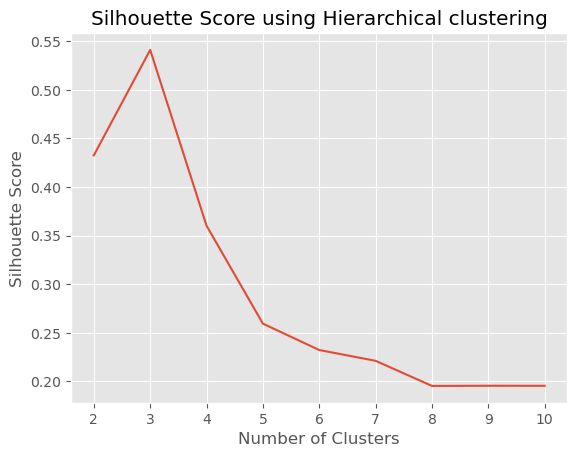

In [177]:
#to determine the optimal number of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clusterer.fit_predict(bank_cc_scaled)
    silhouette_scores.append(silhouette_score(bank_cc_scaled, labels))

# Plot the silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score using Hierarchical clustering')
plt.show()

#### Hierarchical cluster profiling

In [178]:
#build the cluster profile with 3 clusters
clusterer = AgglomerativeClustering(n_clusters=3)
labels = clusterer.fit_predict(bank_cc_scaled)

In [179]:
bank_cc_scaled["HC_Clusters"] = clusterer.labels_
bank_cc["HC_Clusters"] = clusterer.labels_

In [180]:
Hcluster_profile = bank_cc.groupby("HC_Clusters").mean()

In [181]:
# lets display cluster profile
Hcluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,K_means_segments
HC_Clusters,,,,,,,,
0,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,0.000000,0.000000
1,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,1.000000,1.000000
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,2.000000


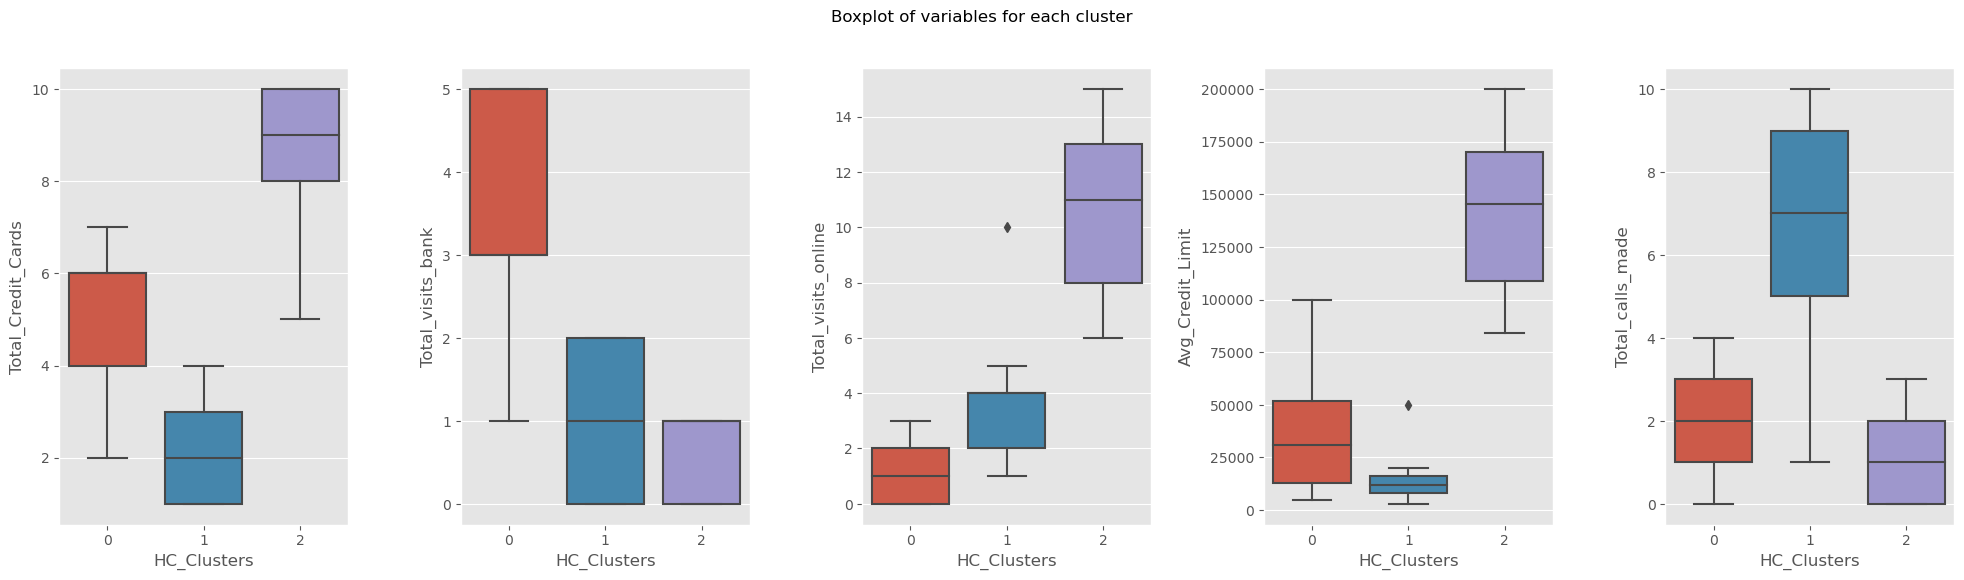

In [182]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle("Boxplot of variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=bank_cc[var_list2[counter]], x=bank_cc["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### observations:
#### Cluster 0:
* Total credit cards is highest
* This cluster appear to visit the bank more regularly than others
* Their online visit traffic is very minimal with some outliers
* Average credit limit is considered the highest though with some outliers
* No of calls is lowest with cluster 2

#### Cluster 1:
* Total credit cards is very low
* Bank visitation is least
* Their online visit traffic is highest
* Average credit limit is considered the least
* No of calls is highest

#### Cluster 2:
* Total credit cards is second to cluster 0
* Total bank visits is higher than cluster 1 but lower than cluster 0
* Their online visit traffic is the least
* Average credit limit is moderate
* No of calls is the same with cluster 0 and lower than cluster 1

### K-means vs Hierarchical Clustering
In comparing both clustering methods with 3 clusters, we observe some similarites and differences as shown below:

In [183]:


# Create row headers and column headers
row_headers = ['K-Means Clustering', 'Hierarchical Clustering']
column_headers = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Create an empty dataframe
df = pd.DataFrame(columns=column_headers, index=row_headers)

# Insert values into the dataframe
df.loc['K-Means Clustering', 'Cluster 0'] = "Moderate"
df.loc['K-Means Clustering', 'Cluster 1'] = 'Low'
df.loc['K-Means Clustering', 'Cluster 2'] = 'High'

df.loc['Hierarchical Clustering', 'Cluster 0'] = "High"
df.loc['Hierarchical Clustering', 'Cluster 1'] = 'Moderate'
df.loc['Hierarchical Clustering', 'Cluster 2'] = 'Low'

# Print the dataframe
print("Total_Credit_Cards:")
print(df)
print('-'*100)

# Create an empty dataframe 2
df1 = pd.DataFrame(columns=column_headers, index=row_headers)

# Insert values into the dataframe
df1.loc['K-Means Clustering', 'Cluster 0'] = "High"
df1.loc['K-Means Clustering', 'Cluster 1'] = 'Moderate'
df1.loc['K-Means Clustering', 'Cluster 2'] = 'Low'

df1.loc['Hierarchical Clustering', 'Cluster 0'] = "High"
df1.loc['Hierarchical Clustering', 'Cluster 1'] = 'Low'
df1.loc['Hierarchical Clustering', 'Cluster 2'] = 'Moderate'
# Print the dataframe
print("Total_visits_bank:")
print(df1)
print('-'*100)


# Create an empty dataframe 3
df2 = pd.DataFrame(columns=column_headers, index=row_headers)

# Insert values into the dataframe
df2.loc['K-Means Clustering', 'Cluster 0'] = "Low"
df2.loc['K-Means Clustering', 'Cluster 1'] = 'Moderate'
df2.loc['K-Means Clustering', 'Cluster 2'] = 'High'

df2.loc['Hierarchical Clustering', 'Cluster 0'] = "Low"
df2.loc['Hierarchical Clustering', 'Cluster 1'] = 'High'
df2.loc['Hierarchical Clustering', 'Cluster 2'] = 'Low'
# Print the dataframe
print("Total_visits_online:")
print(df2)
print('-'*100)

# Create an empty dataframe 4
df3 = pd.DataFrame(columns=column_headers, index=row_headers)

# Insert values into the dataframe
df3.loc['K-Means Clustering', 'Cluster 0'] = "Moderate"
df3.loc['K-Means Clustering', 'Cluster 1'] = 'Low'
df3.loc['K-Means Clustering', 'Cluster 2'] = 'High'

df3.loc['Hierarchical Clustering', 'Cluster 0'] = "High"
df3.loc['Hierarchical Clustering', 'Cluster 1'] = 'Low'
df3.loc['Hierarchical Clustering', 'Cluster 2'] = 'Moderate'
# Print the dataframe
print("Avg_credit_limit:")
print(df3)
print('-'*100)


# Create an empty dataframe 5
df4 = pd.DataFrame(columns=column_headers, index=row_headers)

# Insert values into the dataframe
df4.loc['K-Means Clustering', 'Cluster 0'] = "Moderate"
df4.loc['K-Means Clustering', 'Cluster 1'] = 'High'
df4.loc['K-Means Clustering', 'Cluster 2'] = 'Low'

df4.loc['Hierarchical Clustering', 'Cluster 0'] = "Low"
df4.loc['Hierarchical Clustering', 'Cluster 1'] = 'High'
df4.loc['Hierarchical Clustering', 'Cluster 2'] = 'Low'
# Print the dataframe
print("Total_calls_made:")
print(df4)
print('-'*100)



Total_Credit_Cards:
                        Cluster 0 Cluster 1 Cluster 2
K-Means Clustering       Moderate       Low      High
Hierarchical Clustering      High  Moderate       Low
----------------------------------------------------------------------------------------------------
Total_visits_bank:
                        Cluster 0 Cluster 1 Cluster 2
K-Means Clustering           High  Moderate       Low
Hierarchical Clustering      High       Low  Moderate
----------------------------------------------------------------------------------------------------
Total_visits_online:
                        Cluster 0 Cluster 1 Cluster 2
K-Means Clustering            Low  Moderate      High
Hierarchical Clustering       Low      High       Low
----------------------------------------------------------------------------------------------------
Avg_credit_limit:
                        Cluster 0 Cluster 1 Cluster 2
K-Means Clustering       Moderate       Low      High
Hierarchical Clustering  

## Actionable insights and recommendations:
* The average credit limit ranges from 3,000 to 200,000
* Customers' online visit ranges from none to 15 times. Physical visitation to bank ranges from none to 5 times. So it appears contact preference for customers is via online, bank can leverage this medium for selling more of their products.
* Majority of the existing credit limits is below 25,000. Can the bank do more here to upgrade credit limit and tap from the contributing income.
* It appears customers call mostly up to 4 times, chatbots can also assist the bank to attend to customer inquiries and cut down excessive calls
* the boxplots above reveals some pattern of segmentation in customer behaviour in relation to their credit limit
* Higher limit holders have more credit cards with more online visits , less physical visits and less calls made
* we can determine that 3 is the optimal number of customer segments we can have.
* From the cluster analysis, cluster 2 shows customers with high credit limits and should be more profitable clients to the bank
* Customers segmented in cluster 0 still prefers physical visitation, efforts should be made to migrate them to online banking to save cost
* From both clustering techniques, cluster 1 customers has the highest number of call, more investigation could be done to understand the nature of these calls and ways to minimize if they happen to be more of complaints